In [1]:
import torch
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.cuda.device_count(), device

(0, device(type='cpu'))

In [2]:
import os
import sys
IS_GCOLAB = 'google.colab' in sys.modules

In [3]:
from pathlib import Path

_base_libpath = Path(
    "/content/drive/MyDrive" if IS_GCOLAB else f"{os.environ['HOME']}"
) / "_self_research/24.09.world_cuisine"
assert _base_libpath.exists()

os.chdir(_base_libpath)

In [4]:
if IS_GCOLAB:
    raise NotImplementedError()
    # from google.colab import drive
    # drive.mount('/content/drive')
    # # os.environ.setdefault("", "1")
    # # os.system("pip install transformers==4.33.1")
    # os.system("pip install transformers sudachitra accelerate")
    # os.system("pip install langchain tiktoken openai")
    # os.system("pip install -U langchain-community")
    # os.system("pip install -U datasets pyarrow")

else:
    # raise NotImplementedError()
    print(">>> Not on Google Colab <<<")

>>> Not on Google Colab <<<


---

In [5]:
# import datasets
# from datasets import load_dataset
# from torch.utils.data import DataLoader
# from sentence_transformers import SentenceTransformer

import os
import requests
import pickle
from PIL import Image
from glob import glob
from pathlib import Path
import numpy as np
import pandas as pd

import time
from tqdm import tqdm

In [12]:
df = pd.read_csv("WorldCuisines - Food.csv")
print(f"Cuisine counts: {len(df):6,}")
df = df.loc[df.loc[:,'Image1 name / URL'].notna()].reset_index(drop=True)
print(f"  w/ imgs only: {len(df):6,}")

Cuisine counts:  2,507
  w/ imgs only:    791


In [10]:
fps = []
for _ in range(1,9):
    wew = df.loc[:,f"Image{_} name / URL"].dropna()
    fps.extend(wew.tolist())
fps = pd.Series(fps)

In [11]:
wew = fps.map(lambda t: t[:-len("?download")].lower() if t.endswith("?download") else t.lower())
assert not wew[~(
    wew.str.endswith(".jpg") | wew.str.endswith(".jpeg")
    | wew.str.endswith(".png") | wew.str.endswith(".gif")
)].tolist()
# print(len(wew), len(wew.unique()))

2301 2284


In [12]:
print(f"Image Count: {len(fps)}")
fps = fps[~wew.duplicated()].reset_index(drop=True)
print(f"  Unique # :{len(fps)}")

2301
2284


---

In [ ]:
# assert all(fps[fps.str.startswith("http")].str.startswith("https://"))

In [13]:
def get_img_size(fp):
    headers = {'User-Agent': 'CoolBot/0.0 (https://example.org/coolbot/; coolbot@example.org)'}
    try:
        if fp.startswith("https://"):
            response = requests.get(fp, headers=headers, stream=True, timeout=8)
            response.raise_for_status()
            _img = response.raw
        else:
            _img = _base_libpath / "images" / fp
        image = Image.open(_img).convert('RGB')
        return image.size
    except Exception as e:
        # print(fp, e)
        return None

In [14]:
from multiprocessing import Pool

In [15]:
%%time
with Pool(processes=32) as pool:
    async_result = pool.map_async(get_img_size, fps.tolist(), 16)
    async_result.wait()

CPU times: user 77.7 ms, sys: 177 ms, total: 255 ms
Wall time: 1min 34s


In [16]:
sizes = async_result.get()

In [17]:
len(sizes), len(list(filter(None, sizes))), f"{len(list(filter(None, sizes)))/len(sizes):.1%}"

(2284, 2252, '98.6%')

In [ ]:
# Previous count when total images was 1871

(1856, 1833, '98.8%')

---

In [18]:
import seaborn as sns

In [19]:
df = pd.DataFrame(list(filter(None, sizes)), columns=["width", "height"])

In [20]:
df

,width,height
0,1920,1440
1,1531,1198
2,1564,1199
3,1920,1285
4,1920,1440
...,...,...
2247,1280,960
2248,1440,1080
2249,1434,1080
2250,1280,960


In [21]:
df["hue"] = ""

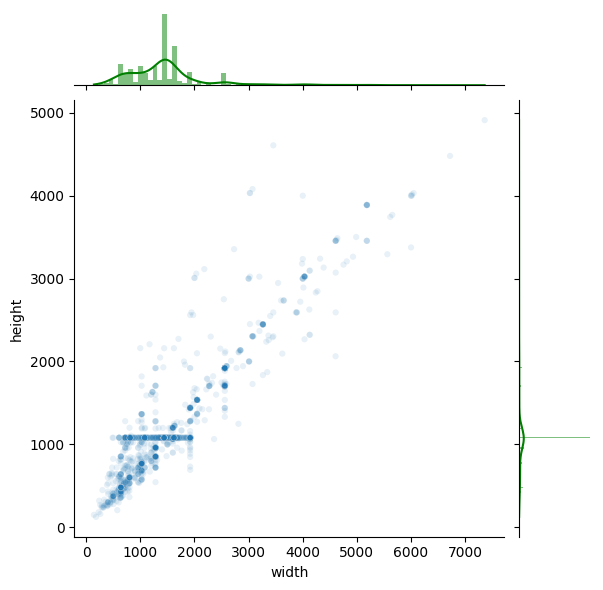

In [22]:
g = sns.JointGrid(df, x="width", y="height", hue="hue")
g.plot_joint(sns.scatterplot, s=20, alpha=.1)
g.plot_marginals(sns.histplot, kde=True, linewidth=0, palette=["g"])

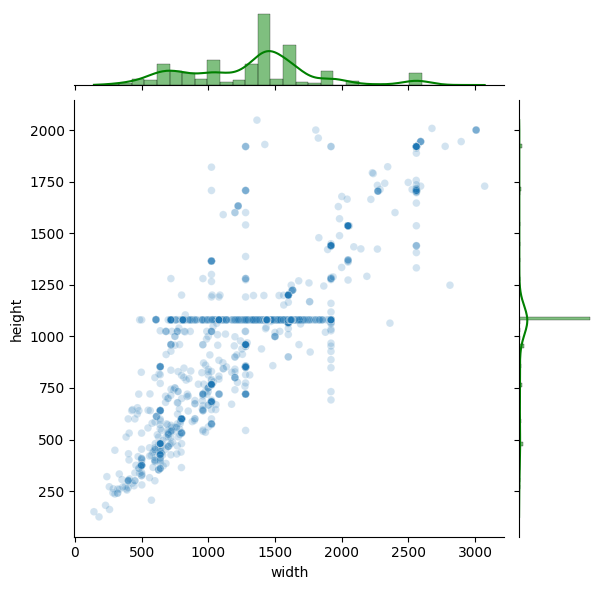

In [23]:
g = sns.JointGrid(df.loc[df.width.le(3072)&df.height.le(2048)], x="width", y="height", hue="hue")
g.plot_joint(sns.scatterplot, s=30, alpha=.2)
g.plot_marginals(sns.histplot, kde=True, linewidth=.2, palette=["g"])

---
---
---

In [178]:
from collections import Counter
import json

In [212]:
df_all = pd.read_csv("WorldCuisines - Food.csv")
print(f"Cuisine counts: {len(df_all):6,}")
df_w_img = df_all.loc[df_all.loc[:,'Image1 name / URL'].notna()].reset_index(drop=True)
print(f"   has images : {len(df_w_img):6,}")
df_w_reg = df_all[df_all.loc[:,'Region1'].notna()].reset_index(drop=True)
print(f"   has Region1: {len(df_w_reg):6,}")

Cuisine counts:  2,507
   has images :    791
   has Region1:    847


In [213]:
print("--- No Images stats ---")
# print(f"Has Region1, w/o imgs. #: {sum(df_all.loc[:,'Region1'].notna())-len(df_w_img):6,}")
print(f"w/ Region1, w/o imgs.: {len(df_w_reg[df_w_reg.loc[:,'Image1 name / URL'].isna()]):6,}")
print(f"    =>  w/  Text Desc. # : {len(df_w_reg[df_w_reg.loc[:,'Text Description'].notna() & df_w_reg.loc[:,'Image1 name / URL'].isna()]):6,}")
print(f"    =>  w/o Text Desc. # : {len(df_w_reg[df_w_reg.loc[:,'Text Description'].isna()]):6,}")

--- No Images stats ---
w/ Region1, w/o imgs.:     56
    =>  w/  Text Desc. # :     39
    =>  w/o Text Desc. # :     17


In [214]:
print("NaN categories also got.\nNo Cuisine also got..\n:\\")
df_w_reg[df_w_reg.iloc[:,4].isna()|df_w_reg.iloc[:,6].isna()].iloc[:,:-14]

NaN categories also got.
No Cuisine also got..
:\


,Count,Name,Alias,Wikipedia Link,Coarse-grained categories,Fine-grained categories,Cuisines,Associated Cuisines,Area,Countries,Region1,Region2,Text Description,Image1 License,Image1 name / URL
38,1,Albaloo polo,آلبالو پلو,https://en.wikipedia.org/wiki/Albaloo_polo,NaN,NaN,"[""Iran""]","[""Shiraz""]","[""Shiraz""]","[""Iran""]",South Asia,NaN,The dish is made with rice and sour cherries u...,NaN,NaN
759,1,Tteokbokki,떡볶이,https://en.wikipedia.org/wiki/Tteokbokki,NaN,"[""Rice Cake""]","[""Korean""]",NaN,NaN,"[""Hong Kong"", ""China""]",East Asia,NaN,NaN,NaN,NaN
762,1,Cap cay,NaN,https://en.wikipedia.org/wiki/Cap_cai,"[""Vegetable""]",NaN,NaN,NaN,NaN,NaN,South East Asia,NaN,NaN,NaN,NaN
766,1,Ugali,NaN,https://en.wikipedia.org/wiki/Ugali,NaN,NaN,NaN,"[""Kenya"",""Tanzania""]",NaN,NaN,West Africa,NaN,* multiple,NaN,NaN
767,1,Bobotie,NaN,https://en.wikipedia.org/wiki/Bobotie,"[""Meat""]",NaN,NaN,NaN,NaN,NaN,South Africa,NaN,NaN,NaN,NaN
768,1,Potjiekos,NaN,https://en.wikipedia.org/wiki/Potjiekos,"[""Meat""]",NaN,NaN,NaN,NaN,NaN,South Africa,NaN,NaN,NaN,NaN
769,1,Vetkoek,NaN,https://en.wikipedia.org/wiki/Vetkoek,NaN,NaN,NaN,NaN,NaN,NaN,South Africa,NaN,NaN,NaN,NaN
770,1,Bunny chow,NaN,https://en.wikipedia.org/wiki/Bunny_chow,"[""Bread""]",NaN,NaN,NaN,NaN,NaN,South Africa,NaN,NaN,NaN,NaN
771,1,Samosa,NaN,https://en.wikipedia.org/wiki/Samosa,"[""Bread""]",NaN,NaN,NaN,NaN,NaN,South Asia,NaN,*multiple,NaN,NaN
772,1,Pirozhki,NaN,https://en.wikipedia.org/wiki/Pirozhki,"[""Bread""]",NaN,NaN,NaN,NaN,NaN,Eastern Europe,NaN,NaN,NaN,NaN


In [215]:
print("Got categories and cuisines, but no description..")
df_w_reg[df_w_reg.iloc[:,4].notna()&df_w_reg.iloc[:,6].notna()&df_w_reg.iloc[:,12].isna()].iloc[:,:-14]

Got categories and cuisines, but no description..


,Count,Name,Alias,Wikipedia Link,Coarse-grained categories,Fine-grained categories,Cuisines,Associated Cuisines,Area,Countries,Region1,Region2,Text Description,Image1 License,Image1 name / URL
424,1,French Fries,NaN,https://en.wikipedia.org/wiki/French_fries,"[""Potato""]","[""Deep-Fried Potato""]","[""United States"", ""Canada""]",NaN,"[""United States"", ""Canada""]",NaN,North America,NaN,NaN,NaN,NaN
643,1,Butter pecan,NaN,https://en.wikipedia.org/wiki/Butter_pecan,['Dessert'],['ice cream'],['America'],['America'],['America'],['America'],North America,NaN,NaN,NaN,NaN
758,1,Takoyaki,たこ焼き,https://en.wikipedia.org/wiki/Takoyaki,"[""Side dish""]",NaN,"[""Japan""]",NaN,"[""Osaka""]","[""Japan""]",East Asia,NaN,NaN,NaN,NaN
760,1,Chee Cheong Fun,NaN,https://ms.wikipedia.org/wiki/Chee_cheong_fun,"[""Side dish""]","[""Rice Cake""]","[""Canton""]",NaN,NaN,NaN,East Asia,NaN,NaN,NaN,NaN
761,1,Plecing Kangkung,NaN,https://en.wikipedia.org/wiki/Plecing_kangkung,"[""Vegetable""]",NaN,"[""Indonesia""]","[""Indonesia""]","[""Bali"",""Lombok""]","[""Indonesia""]",South East Asia,NaN,NaN,NaN,NaN
763,1,Sayur lodeh,NaN,https://en.wikipedia.org/wiki/Sayur_lodeh,"[""Vegetable""]",NaN,"[""Indonesia""]","[""Indonesia""]","[""Java""]","[""Indonesia""]",South East Asia,NaN,NaN,NaN,NaN
764,1,Sayur asem,NaN,https://en.wikipedia.org/wiki/Sayur_asem,"[""Vegetable"",""Soup""]",NaN,"[""Indonesia""]","[""Indonesia""]","[""Jakarta"", ""Java"",""Banten""]","[""Indonesia""]",South East Asia,NaN,NaN,NaN,NaN
765,1,Efo riro,NaN,https://en.wikipedia.org/wiki/Efo_riro,"[""Vegetable"",""Soup""]",NaN,"[""Nigeria""]","[""Nigeria""]",NaN,NaN,West Africa,NaN,NaN,NaN,NaN
774,1,Konro,NaN,https://en.wikipedia.org/wiki/Konro,"[""Soup""]","[""Beef Soup""]","[""Indonesia""]","[""Indonesia""]","[""Makassar""]","[""Indonesia""]",South East Asia,NaN,NaN,NaN,NaN


Let's check the stats

In [216]:
df = df_w_reg[df_w_reg.iloc[:,4].notna()&df_w_reg.iloc[:,6].notna()&df_w_reg.iloc[:,12].notna()]
print(f"Somewhat OK count: {len(df)}")

Somewhat OK count: 827


In [255]:
# @title
def parse_txt(t):
    if t is np.nan:
        return []
    t = t.replace("''", '"')
    t = re.sub(r"[‘'’“]", '"', t)
    t = re.sub(r'", ([A-Z])', r'", "\1', t)
    t = re.sub(r'([a-z])\]', r'\1"]', t)
    t = (t
            .replace('" "', '", "')
            .replace('"."', '", "')
            .replace('d"Ivoire', "d'Ivoire")
        )
    return json.loads(t)


In [219]:
entries = df.iloc[:,4:-19]

In [313]:
for c in range(6):
    wew = Counter([e.lower() for _ in entries.iloc[:,c].apply(parse_txt) for e in _])
    print(entries.columns[c], f"  (total:  {sum(wew.values()):,})")
    print(wew, end="\n\n")

Coarse-grained categories   (total:  962)
Counter({'rice': 209, 'snack': 142, 'noodle': 112, 'dessert': 101, 'pastry': 52, 'bread': 50, 'meat': 30, 'pancake': 29, 'cake': 27, 'soup': 24, 'side dish': 24, 'tofu': 21, 'stew': 20, 'dumpling': 18, 'sweet': 10, 'fish': 9, 'potato': 6, 'dim sum': 5, 'cutlet': 5, 'skewer': 5, 'chicken': 4, 'pasta': 4, 'crepe': 4, 'vegetables': 3, 'seafood': 3, 'sandwich': 3, 'hot pot': 3, 'shrimp': 2, 'lamb': 2, 'wrap': 2, 'fritter': 2, 'cold dessert': 2, 'chili paste': 2, 'egg': 2, 'corn': 2, 'pudding': 2, 'dough': 1, 'fruit': 1, 'shellfish': 1, 'drinks': 1, 'rice cake': 1, 'cereal': 1, 'curry': 1, 'dimsum': 1, 'canned food': 1, 'salad': 1, 'finger food': 1, 'omelette': 1, 'doughnut': 1, 'soybeans': 1, 'bean': 1, 'flatbread': 1, 'biscuit': 1, 'seaweed': 1, 'grill': 1, 'mutton': 1, 'sugar': 1})

Fine-grained categories   (total:  1,046)
Counter({'mixed rice': 107, 'rice cake': 59, 'biscuit': 44, 'noodle soup': 41, 'cookie': 32, 'rice noodle': 28, 'pancake': 2